In [19]:
import os
import sys
import re
from operator import itemgetter
from datetime import datetime
from langchain.document_loaders.text import TextLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models.openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, base, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.pydantic_v1 import BaseModel, Field
from langchain.vectorstores import qdrant
from config import GPT_API
import re
from typing import Annotated, List, Dict, TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langsmith import Client

os.environ["OPENAI_API_KEY"] = GPT_API
os.environ["LANGCHAIN_API_KEY"] = "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"

from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough {unique_id}"
current_date = datetime.now().strftime('%B%Y')


In [20]:
client = Client()

In [21]:
SET_TEMPERATURE = 0.2
MODEL = "gpt-4o-2024-05-13"#"gpt-3.5-turbo"

LLM_MODEL = ChatOpenAI(
    model=MODEL,
    name="Agent for job applications",
    temperature=SET_TEMPERATURE,
    n=1,
    )

In [22]:
# loader = TextLoader("ai_engineer_software_engineer.txt")

loader = DirectoryLoader(path="jobtemplates/")

load_applications = loader.load()

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    encode_kwargs = {'normalize_embeddings':False}
)

vectorstore = qdrant.Qdrant.from_documents(
    documents=load_applications,
    embedding=embedding_model,
    location=":memory:"
)

retriver = vectorstore.as_retriever(search_type="similarity",
                                    search_kwargs={'k': 1})

In [23]:
skills = [
    ##
    "Business analytics",
    "Business maturity",
    "Strategy",
    "Non-technical and technical communication",
    "Algorithms & datastrucures",
    "Software Engineering",
    "detail oriented",
    "Creative thinker",
    "Problem solving",
    "Critical thinking",
    "Team player",
    "Time management",
    "Adaptability",
    "Conflict resolution",
    "Collaborative",
    "Dilligent",
    "Software development",
    ## management
    "ITIL",
    "SAFe",
    "PRINCE2",
    "CMMI",
    "SCRUM",
    "Agile development",
    "UML(frequency, class or C4)",
    "Stakeholder classification",
    ## technical
    "Python intermediate level",
    "SQL working understanding",
    "R working understanding",
    "JavaScript working understanding",
    "Git"
    "Statistical modelling",
    "Fundamental Azure knowledge",
    "PostGres",
    "Neo4J",
    "Qdrant",
    "ANNOY",
    "Docker",
    "scraping",
    "crawling",
    "MT5",
    "Bert",
    "FinBert",
    "T5",
    "Scrapy",
    "Numpy",
    "Polars",
    "Pandas",
    "FastAPI",
    "VUE3",
    "TensorFlow2",
    "Huggingface",
    "Pytorch",
    "SonarCube",
    "Seaborn(/matplotlib/Plotly)",
    "PyTest",
    "SKlearn"
    "Unsupervised learning: dimensionality reduction, explorative factor analysis, K-mean..",
    "Supervised learning: Random Forests, multiple logistic regression, SVP, NNs, Classification",
]


do_not_use_words = [
    "abreast",
    "ardent",
    "cruisal",
    "deeply",
    "eagerly",
    "endeavors",
    "enhance",
    "enhanced",
    "enhancing",
    "extensive",
    "extensively", 
    "expert",
    "expertise",
    "facets"
    "forefront",
    "fostering",
    "fueled",
    "fulfilling",
    "honed",
    "intricacies",
    "intricate",
    "meticulous ",
    "perfect",
    "perfectly",
    "prowess",
    "profoundly",
    "realm",
    "seamlessly",
    "specialist",
    "stems",
    "thrilled",
    "versed",
    "seamlessly"
]


In [24]:
query_for_search = """
About the job
Hos Autorola er vi drevet af visionen om at forandre bilbranchen gennem innovative løsninger. Vi søger en passioneret kollega til at udvikle AI chatbots, som vil blive en central del af vores produkter. Vi kalder disse personlige assistenter for CoPilots, og de vil sætte en ny standard for brugervenlighed ved at tilbyde en skræddersyet og effektiv oplevelse baseret på den enkeltes kontekst og præferencer. Din passion inden for chatbot-udvikling er afgørende for at realisere denne vision og sikre, at Autorola forbliver i front med brugervenlige systemer. Bliv en del af vores innovative team og vær med til at forme fremtidens løsninger.

For at lykkes i rollen skal du være en selvstændig og engageret person. Du er nysgerrig af natur og har lyst til at holde dig fagligt opdateret. En vigtig del af jobbet er løbende at hold dig opdateret om chatbots og de muligheder, de giver.

Du bliver en del af Autorola’s AI-Team der består, indtil videre, af en Data Scientist og en matematikstuderende. Teamet refererer direkte til den tekniske direktør.

Du skal arbejde med følgende opgaver:

Projektstyring i forbindelse med design, udvikling, og implementering af interne ChatBots der kan tilpasse sig brugernes kontekst, adfærd og præferencer, og dermed give dem en mere effektiv og personlig brugeroplevelse
Eksplorativ undersøgelse og test af potentielle chatbot løsninger.
Udvikle politikker og brugerguides til chatbots.
På sigt, etablere integrationen af chatbots og copilots med vores backend-systemer, så de kan levere realtidsdata og relevante svar til brugerne.

Du har den rigtige profil til jobbet hvis du:

Har en relevant uddannelse, gerne på kandidatniveau inden for datavidenskab, matematik, sprog eller lignende.
Har interesse for området og nysgerrig på at lære nyt. Erhvervserfaring er en fordel men ikke et krav.
Har teknisk forståelse.
Har erfaring med Python.
Taler og skriver dansk og engelsk på et professionelt niveau.
Er nysgerrig, selvstændig og ansvarsbevidst.

Om os og det vi tilbyder

Autorola-koncernen er global og specialiseret i online bilauktioner og IT-løsninger til bilbranchen. Vi er en veletableret virksomhed, men vi har stadig en stærk iværksætterånd, som går hånd i hånd med en god og afslappet atmosfære.
Du får en 37-timers arbejdsuge med flekstid, så der også er fleksibilitet til familielivet og fritiden. Vi ved, at det er vigtigt at have balance mellem arbejde og fritid, og vi passer på vores medarbejdere. Derfor har vi også fokus på at holde et arbejdspres, som giver tid til at løse opgaverne fornuftigt.
Vi bor lige ved banegården i Odense, hvor vi arbejder i et åbent kontorlandskab, der er præget af en uformel omgangstone. Desuden har vi løbende forskellige firmaarrangementer, god kantineordning, pensionsordning og sundhedsforsikring samt et fitnessrum. Vi slutter gerne ugen af i vores fredagsbar i kælderen.

"""


semilarity_document_template = vectorstore.similarity_search_with_score(
    query = query_for_search,
    k = 1,
    score_threshold=0.1)

In [25]:
## Vacancy analysis LLM
## Output data structure
class OutputStuctureV1(BaseModel):
    company_name: str = Field(description="identified company name")
    job_title: str = Field(description="identified job title")
    analysis_output: str = Field(description="analysis of the job vacancy")
    employees_skills_requirement: dict = Field(description="identified skills and technical experience required for the job vacancy")
    matching_skills: dict = Field(description="matching skills in the job vacancy")


analysis_parser = PydanticOutputParser(pydantic_object=OutputStuctureV1)

system_analysis_template_str = """
    You are an assisatant to a human resource manager//
    You are to assist in the analysis of a job vacancy//
    Identify vocal points of interest that the company is looking for//
    Identify the company name//
    Identify the job title//
    Identify the skills and technical experience required for the job vacancy provided here to be stored as a dictionary employee skill requirement//
    Use these skills {my_skills} to conduct an analysis between job requirements and find matching skills//
    Output should contain a list of matching skills required for the job vacancy//
    {format_messages}
    """

SYSTEM_ANALYSIS_PROMT = SystemMessagePromptTemplate(
    prompt = PromptTemplate(
        template=system_analysis_template_str,
        input_variables=["my_skills"],
        partical_variables={"format_messages": analysis_parser.get_format_instructions()}
    )
)

human_analysis_template_str = """
    Given the job vacancy, you are to analyse the following in detail: {job_position}//
    {format_messages}
"""

HUMAN_ANALYSIS_PROMPT = HumanMessagePromptTemplate(
    prompt = PromptTemplate(
        template=human_analysis_template_str,
        input_variables=["job_position"],
        partical_variables={"format_messages": analysis_parser.get_format_instructions()}
    )
)

analysis_messages = [SYSTEM_ANALYSIS_PROMT, HUMAN_ANALYSIS_PROMPT]

analysis_review_template = ChatPromptTemplate(
    messages=analysis_messages
)

pydantic_analysis_formatter = analysis_parser.get_format_instructions()

generate_analysis_of_job = analysis_review_template | LLM_MODEL | analysis_parser

analysis_review_template.format_messages(
    my_skills=skills, 
    job_position=query_for_search, 
    format_messages=pydantic_analysis_formatter)

analysis_chain = generate_analysis_of_job.invoke(
    {
        "job_position":query_for_search, 
        "my_skills":skills, 
        "format_messages":pydantic_analysis_formatter
    }
)

In [26]:
analysis_review_template

ChatPromptTemplate(input_variables=['format_messages', 'job_position', 'my_skills'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_messages', 'my_skills'], template='\n    You are an assisatant to a human resource manager//\n    You are to assist in the analysis of a job vacancy//\n    Identify vocal points of interest that the company is looking for//\n    Identify the company name//\n    Identify the job title//\n    Identify the skills and technical experience required for the job vacancy provided here to be stored as a dictionary employee skill requirement//\n    Use these skills {my_skills} to conduct an analysis between job requirements and find matching skills//\n    Output should contain a list of matching skills required for the job vacancy//\n    {format_messages}\n    ')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_messages', 'job_position'], template='\n    Given the job vacancy, you are to analyse the fo

In [27]:
# Extracting identified information from analysis_chain
identified_company_name = analysis_chain.company_name
identified_job_title = analysis_chain.job_title
identified_skill_requirements = analysis_chain.employees_skills_requirement
identified_matching_skills = analysis_chain.matching_skills
identified_analysis_output = analysis_chain.analysis_output

# Create the output dictionary according to the schema
output = {
    "company_name": identified_company_name,
    "job_title": identified_job_title,
    "analysis_output": identified_analysis_output,
    "employees_skills_requirement": identified_skill_requirements
}

# Getting keys from the dictionary
get_employee_requirements_keys = identified_skill_requirements.keys()

# Create an itemgetter object with these keys
get_employee_requirements_lists = itemgetter(*get_employee_requirements_keys)

# Applying itemgetter to the dictionary to get the lists
employee_requirements = get_employee_requirements_lists(identified_skill_requirements)

# Zipping keys with their corresponding lists
lists_with_employee_requirements = zip(get_employee_requirements_keys, employee_requirements)

# If you need to process lists_with_employee_requirements further, you can do so here
get_matching_skills_keys = identified_matching_skills.keys()
get_matching_skills_lists = itemgetter(*get_matching_skills_keys)
matching_skills = get_matching_skills_lists(identified_matching_skills)
lists_with_matching_skills = zip(get_matching_skills_keys, matching_skills)
# Example usage:
# print the output dictionary
print(list(lists_with_employee_requirements))
print(list(lists_with_matching_skills))





[('education', "Relevant education, preferably at the master's level in data science, mathematics, linguistics, or a related field."), ('experience', 'Experience in the field is advantageous but not mandatory.'), ('technical_skills', ['Technical understanding', 'Experience with Python']), ('languages', ['Professional proficiency in Danish and English']), ('personal_traits', ['Curious', 'Independent', 'Responsible'])]
[('Python intermediate level', True), ('Non-technical and technical communication', True), ('Problem solving', True), ('Critical thinking', True), ('Team player', True), ('Adaptability', True), ('Collaborative', True), ('Dilligent', True)]


In [28]:
class OutputStuctureV2(BaseModel):
    company_name: str = Field(description="Company name")
    job_title: str = Field(description="Job title")
    introduction: str = Field(description="Introduction")
    motivation: str = Field(description="Motivation")
    skills: str = Field(description="Skills")
    education: str = Field(description="Education")
    continued_learning: str = Field(description="Continued learning")
    thank_you: str = Field(description="Thank you for your time")

cover_letter_parser = PydanticOutputParser(pydantic_object=OutputStuctureV2)

system_generate_cover_letter_template_str = """
    You are to assist in wrting a professional cover latter for a job//
    The total amount of characters that can be used is 4000, including white spaces//
    300 characters for the introduction section//
    1000 characters for the motivation section//
    800 characters for the skills section//
    900 characters education section//
    300 characters for the continued learning section//
    200 characters for the thank you note//
    This template is the jobtemplate: {semilarity_jobtemplate}// 
    Grammatical correctness is essential//
    Use casual business language//
    Ensure, the English language is equal to EITLS c1 score//
    The template job application must be in English//
    {format_cover_letter_messages}
    """

SYSTEM_GENERATE_COVER_LETTER_PROMT = SystemMessagePromptTemplate(
    prompt = PromptTemplate(
        template=system_generate_cover_letter_template_str,
        input_variables=["semilarity_jobtemplate"],
        partical_variables={"format_cover_letter_messages": cover_letter_parser.get_format_instructions()}
    )
)

human_generate_cover_letter_template_str = """
I have the following knowledge and skills which can be found in the following dictionary {my_skills}//
write two lines to generate a short introduction with interest in IT and AI with inspiration from the {analysis_output}//
write motivation with matching pairs {skill_match} and {employee_requirements} and how these can be utilized for the company's benefi//
write a section about skills somme of the skills and how they can be utilized for the company's benefit//
keep educational background for later access and save the section about education//
keep continued learning section and provide short context that I am willing to learn what is necessary for the company and specific role//
write a short and consice thank you note to setup a coffee//
I DO NOT have prior experience in a professional environment in programming, ONLY academia//
I DO have prior experience in project management//
Validate, that the generated cover letter is not using any of these words found here {forbidden_words}//
{format_cover_letter_messages}
"""

HUMAN_GENERATE_COVER_LETTER_PROMPT = HumanMessagePromptTemplate(
    prompt = PromptTemplate(
        template=human_generate_cover_letter_template_str,
        input_variables=["my_skills", "analysis_output", "skill_match", "employee_requirements",  "forbidden_words"],
        partical_variables={"format_cover_letter_messages": cover_letter_parser.get_format_instructions()}
    )
)



cover_letter_messages = [SYSTEM_GENERATE_COVER_LETTER_PROMT, HUMAN_GENERATE_COVER_LETTER_PROMPT]

cover_letter_review_template = ChatPromptTemplate(
    messages=cover_letter_messages
)


pydantic_cover_letter_formatter = cover_letter_parser.get_format_instructions()

cover_letter_review_template.format_messages(
    semilarity_jobtemplate = semilarity_document_template,
    my_skills = skills, 
    analysis_output = analysis_chain,
    skill_match = matching_skills,
    employee_requirements = employee_requirements,
    forbidden_words = do_not_use_words,
    format_cover_letter_messages = pydantic_cover_letter_formatter,
)

generate_cover_letter = cover_letter_review_template | LLM_MODEL | cover_letter_parser


cover_letter = generate_cover_letter.invoke(
    {
        "job_position":query_for_search, 
        "semilarity_jobtemplate": semilarity_document_template, 
        "my_skills":skills, 
        "analysis_output":analysis_chain, 
        "skill_match":matching_skills, 
        "employee_requirements":employee_requirements, 
        "forbidden_words":do_not_use_words, 
        "format_cover_letter_messages":pydantic_cover_letter_formatter
    }
)


In [29]:
max_iterations = 5

class GraphState(TypedDict):
    """
    TypedDict for the graph state.

    Args:
        TypedDict: Base class for TypedDict.
    """
    error: str
    messages: Annotated[List[AnyMessage], add_messages]
    generation: str
    iterations: int
    final: dict
    cover_letter_template: str

def retrieve_cover_letter(state: GraphState) -> GraphState:

    retrieve_cover_letter_template = retriver.invoke(query_for_search)

    return {
        "message": query_for_search,
        "cover_letter_template": retrieve_cover_letter_template,
    }

def generate_vacancy_analysis(state: GraphState) -> GraphState:
    
    print("------ Analysing vacancy ------")
        # State
    messages = state['messages']
    iterations = state['iterations']

    vacancy_analysis = generate_analysis_of_job.invoke(
    {
        "job_position": query_for_search, 
        "my_skills": skills, 
        "format_messages": pydantic_analysis_formatter
    }
)
    print('------ VACANCY ANALYSIS COMPLETE ------')
    
    return {
        "messages": messages,
        "iterations": iterations,
        "generation": vacancy_analysis
    }
    

def generate_application(state: GraphState) -> GraphState:
    """
    Generate a job application based on the job template provided.

    Args:
        state (GraphState): The current graph state.

    Returns:
        state (dict): New key added to state, generation.
    """

    print("------ Generating application ------")
    # State
    messages = state['messages']
    iterations = state['iterations']
    error = state['error']
    generation_cover_letter = state['generation']
    retrieve_cover_letter_template = state["cover_letter_template"]
    
    # Generate solution
    generation_cover_letter = generate_cover_letter.invoke(
        {
            "job_position": query_for_search, 
            "semilarity_jobtemplate": retrieve_cover_letter_template, 
            "my_skills": skills, 
            "analysis_output": analysis_chain, 
            "skill_match": matching_skills, 
            "employee_requirements": employee_requirements, 
            "forbidden_words": do_not_use_words, 
            "format_cover_letter_messages": pydantic_cover_letter_formatter
        },
    )
    messages += [
            ('assistant', f"""Here is the attempt to generate a professional cover letter: {generation_cover_letter.introduction}, {generation_cover_letter.motivation}, {generation_cover_letter.skills}, {generation_cover_letter.education}, {generation_cover_letter.continued_learning}, {generation_cover_letter.thank_you}""")
        ]

    # Increment iterations
    iterations = iterations + 1

    return {
        "generation": generation_cover_letter,
        "messages": messages,
        "iterations": iterations,
        "error": error
    }

def new_validate_words(do_not_use_words: list[str], component_value: str) -> str:
    # Dummy implementation for demonstration purposes
    found_words = [word for word in do_not_use_words if word in component_value]
    if found_words:
        raise ValueError(f"Invalid words found: {', '.join(found_words)}")
    
    return component_value

def check_generation(state: GraphState) -> GraphState:
    """
    Check the generated application for errors.

    Args:
        state (GraphState): The current graph state.

    Returns:
        state (GraphState): Updated graph state with error status.
    """

    # State
    messages = state['messages']
    iterations = state['iterations']
    error = state['error']
    generation = state['generation']
    no_go_words = [
    "abreast",
    "ardent",
    "cruisal",
    "deeply",
    "eagerly",
    "endeavors",
    "enhance",
    "enhanced",
    "enhancing",
    "extensive",
    "extensively", 
    "expert",
    "expertise",
    "facets"
    "forefront",
    "fostering",
    "fueled",
    "fulfilling",
    "honed",
    "intricacies",
    "intricate",
    "meticulous ",
    "perfect",
    "perfectly",
    "prowess",
    "profoundly",
    "realm",
    "seamlessly",
    "specialist",
    "stems",
    "thrilled",
    "versed"
]
    print("---------------- CHECK GENERATION ----------------")

    generation_components = {
        "company_name": generation.company_name,
        "job_title": generation.job_title,
        "introduction": generation.introduction,
        "motivation": generation.motivation,
        "skills": generation.skills,
        "education": generation.education,
        "continued_learning": generation.continued_learning,
        "thank_you": generation.thank_you
        }

    length_requirements = {
        "company_name": (2, 100),
        "job_title": (2, 100),
        "introduction": (300, 300),
        "motivation": (1000, 1000),
        "skills": (800, 800),
        "education": (800, 900),  # Adjusted for combined length of education fields
        "continued_learning": (300, 300),
        "thank_you": (200, 200)
        }
    
    # try:
    print("---APPLICATION CHECK: START---")
    all_errors = []
    for component_name, component_value in generation_components.items():
        component_errors = []
        
        try:
            # Validate words in the component_value
            new_validate_words(no_go_words, component_value)
        except ValueError as ve:
            print(f"Invalid words in: {component_name}: {ve}")
            component_errors.append(f"Invalid words in {component_name}: {ve}")
            print("INVALID WORDs: ",component_errors)

        # Length validation
        min_length, max_length = length_requirements[component_name]
        if len(component_value) < min_length:
            print("------------- MIN LENGTH ERROR -------------")
            component_errors.append(f"{component_name}: Expected at least {min_length} characters, but got {len(component_value)}")

        if len(component_value) > max_length:

            print("------------- MAX LENGTH ERROR -------------")
            component_errors.append(f"{component_name}: Expected at most {max_length} characters, but got {len(component_value)}")

        if component_errors:
            all_errors.extend(component_errors)
        else:
            # Store the valid component value
            setattr(generation, component_name, component_value)

    if all_errors != [None]:
        error_message = [(
            "user", f"Failed with the following errors: {all_errors}. Revieww and reflect these errors and prior attempts to solve the issue. #1 state what you think went wrong and #2 try to solve this problem again. Return full solution. Use the output structure with company_name, job_title, introduction, motivation, skills, education, continued_learning, thank_you.")]
        messages += error_message
        error = "yes"


    else:
        print("--- NO APPLICATION ERRORS ---")
        error = "no"

    print(f"Checking errors for: {component_errors}")
    print(f"ALL ERRORS: {all_errors}")
    # except Exception as e:
    #     print("--- APPLICATION CHECK: FAILED outer---")
    #     error_message = [(
    #         "user", f"Your generated application failed with: {e}. Reflect and review this error and prior attempts to solve the issue. #1 state what you think went wrong and #2 try to solve this problem again. Return full solution. Use the output structure with company_name, job_title, introduction, motivation, skills, continued_learning, thank_you.")]
    #     messages += error_message
    #     error = "yes"
    
    return {
        "generation": generation,
        "messages": messages,
        "iterations": iterations,
        "error": error
    }


def decide_to_finish(state: GraphState) -> GraphState:
    """
    Determines whether to finish or retry based on the error status and iteration count.

    Args:
        state (GraphState): The current graph state.

    Returns:
        str: Next node to call.
    """

    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations >= max_iterations:

        return "check_latex_syntax"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate_application"


################# does not work yet. state['generation'] is a tuple, not a string. So regrex does not work because it has to be a string.
################# I will try to fix this later. Not important for now, since the main goal is to get the application to work and automate.
def check_latex_syntax(state: GraphState) -> GraphState:
    print("------ Checking LaTeX syntax ------")
    
    # State
    generation = state['generation']
    
    generation_components = {
        "company_name": generation.company_name,
        "job_title": generation.job_title,
        "introduction": generation.introduction,
        "motivation": generation.motivation,
        "skills": generation.skills,
        "education": generation.education,
        "continued_learning": generation.continued_learning,
        "thank_you": generation.thank_you
    }

    # Dictionary to map LaTeX special characters to their safe equivalents
    replacements = {
        '\\': ' ',          # backslash to space
        '{': ' ',           # curly brace to space
        '}': ' ',           # curly brace to space
        '#': ' ',           # hash to space
        '%': ' ',           # percent to space
        '&': 'and',         # ampersand to 'and'
        '_': ' ',           # underscore to space
        '^': ' ',           # caret to space
        '~': ' ',           # tilde to space
        '$': 'dollars',     # dollar to space
        '/': ' ',           # slash to space
        '*': ' ',           # asterisk to space
        '-': ' '            # hyphen to space
    }
    
    # Regex pattern to match any LaTeX special character
    pattern = r'[\\{}#%&_^\~$\/\*\-]'
    
    # Function to replace matched characters
    def replace_match(match):
        return replacements[match.group(0)]
    
    # Process each input text and update the dictionary
    for component_name, component_value in generation_components.items():
        # print(type(component_value), "DTYPE")
        # print(component_value, "COMPONENT VALUE")
        
        if not isinstance(component_value, str):
            raise TypeError(f"Expected a string, but got {type(component_value)}")
        
        if re.search(pattern, component_value):
            print(f"Found LaTeX special characters in: {component_value}")
            safe_text = re.sub(pattern, replace_match, component_value)
            print(f"Replaced with safe characters: {safe_text}")
        else:
            safe_text = component_value
        
        # Update the dictionary with the sanitized value
        generation_components[component_name] = safe_text

    print(f"Validate latex safety: {generation_components}")

    return {
        "generation": generation,
        "final": generation_components
    }

def create_latex_pdf(state: GraphState) -> GraphState:
    # State
    generation = state['generation']
    final = state['final']

    print("------ Creating LaTeX PDF ------")
    print(final, "-------------- check if latex safe variables are here")
    # Access solution components
    company_name = generation.company_name
    job_title = generation.job_title
    introduction = generation.introduction
    motivation = generation.motivation
    skills = generation.skills
    education = generation.education
    continued_learning = generation.continued_learning
    thank_you = generation.thank_you

    # Directory where the variables.tex file will be saved
    directory = 'companies_applied_for'

    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    company_directory = os.path.join(directory, company_name)
    if not os.path.exists(company_directory):
        os.makedirs(company_directory)

    print("------ Creating LaTeX PDF ------")
    # Write these variables to a .tex file in the specified directory
    resume_file_path = os.path.join(company_directory, company_name + '.tex')
    with open(resume_file_path, 'w') as text_for_latex:
        text_for_latex.write(f"\\newcommand{{\\finalCompanyName}}{{{company_name}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalJobtitle}}{{{job_title}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalIntroduction}}{{{introduction}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalMotivation}}{{{motivation}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalSkills}}{{{skills}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalEducationBoth}}{{{education}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalContinuedLearning}}{{{continued_learning}}}\n")
        text_for_latex.write(f"\\newcommand{{\\finalThankYou}}{{{thank_you}}}\n")

    latex_filename = f'JMangabat_{company_name}_{job_title}_{current_date}.tex'

    latex_file_path = os.path.join(company_directory, latex_filename)

    # Check if the file already exists and create a unique file name if it does
    file_counter = 1
    while os.path.exists(latex_file_path):
        new_file_name = f'JMangabat_{company_name}_{job_title}_{current_date}_{file_counter}.tex'
        latex_file_path = os.path.join(company_directory, new_file_name)
        file_counter += 1


    tex_content = tex_content = f"""
    %----------------------------------------------------------------------------------------
    % PACKAGES AND OTHER DOCUMENT CONFIGURATIONS
    %----------------------------------------------------------------------------------------

    \\documentclass{{article}}
    % \\usepackage{{charter}} % Use the Charter font
    \\usepackage{{graphicx}} % Required for including images
    \\usepackage{{fancyhdr}} % Required for customizing headers and footers
    \\usepackage{{setspace}} % Remove paragraph indentation
    \\usepackage{{titlesec}} % Used to customize the \\section command
    \\usepackage[
        a4paper, % Paper size
        top=15mm, % Top margin
        bottom=15mm, % Bottom margin
        left=15mm, % Left margin
        right=15mm, % Right margin
        % showframe % Uncomment to show frames around the margins for debugging purposes
    ]{{geometry}}

    % \\setlength{{\\parindent}}{{0pt}} % Paragraph indentation
    \\setlength{{\\parskip}}{{-0.7em}} % Vertical space between paragraphs

    \\fancypagestyle{{firstpage}}{{%
        \\fancyhf{{}} % Clear default headers/footers
        \\renewcommand{{\\headrulewidth}}{{0pt}} % No header rule
        \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
    }}

    \\fancypagestyle{{subsequentpages}}{{%
        \\fancyhf{{}} % Clear default headers/footers
        \\renewcommand{{\\headrulewidth}}{{1pt}} % Header rule thickness
        \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
    }}

    \\input{{{company_name}.tex}}

    \\AtBeginDocument{{\\thispagestyle{{firstpage}}}} % Use the first page headers/footers style on the first page
    \\pagestyle{{subsequentpages}} % Use the subsequent pages headers/footers style on subsequent pages
    %----------------------------------------------------------------------------------------
    %----------------------------------------------------------------------------------------
    \\begin{{document}}
    \\rule{{\\linewidth}}{{1pt}} % Horizontal rule

    % Use the commands in your document
    \\begin{{center}}
        Jannik M. B. Sørensen |
        Email: Mangabat93@gmail.com | 
        Odder, Denmark | Date
    \\end{{center}}

    \\subsection*{{\\finalJobtitle, \\finalCompanyName}}
        \\begin{{spacing}}{{1.2}}
            {{\\finalIntroduction}}
        \\end{{spacing}}
        \\vspace*{{0mm}}

    \\subsection*{{Motivation}}
        \\begin{{spacing}}{{1.2}}
            {{\\finalMotivation}}
        \\end{{spacing}}
        \\vspace*{{0mm}}

    \\subsection*{{Skills}}
        \\begin{{spacing}}{{1.2}}
            {{\\finalSkills}}
        \\end{{spacing}}
        \\vspace*{{0mm}}

    \\subsection*{{Education}}
    % Masters degree
        \\begin{{spacing}}{{1.2}}
            {{\\finalEducationBoth}}\\\\
        \\vspace*{{0mm}}

    \\subsection*{{Continued Learning}}
        \\begin{{spacing}}{{1.2}}
            {{\\finalContinuedLearning}}
        \\end{{spacing}}
        \\vspace*{{0mm}}

    \\subsection*{{Thanks for your time}}
        \\begin{{spacing}}{{1.2}}
            {{\\finalThankYou}}\\\\        
        \\end{{spacing}}

    \\noindent Kind regards,\\\\
        Jannik Mangabat
    %----------------------------------------------------------------------------------------
    % LETTER CONTENT
    %----------------------------------------------------------------------------------------

    \\end{{document}}
    """

    with open(latex_file_path, 'w') as file:
        file.write(tex_content)


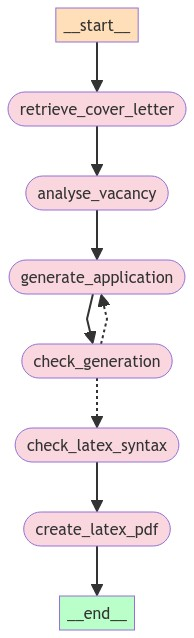

In [30]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

# Initialize the graph
work_flow = StateGraph(GraphState)

# Define the nodes
work_flow.add_node("retrieve_cover_letter", retrieve_cover_letter)  # retrieve cover letter
work_flow.add_node("analyse_vacancy", generate_vacancy_analysis)  # analyse vacancy
work_flow.add_node("generate_application", generate_application)  # generation solution
work_flow.add_node("check_generation", check_generation)  # check generation
work_flow.add_node("check_latex_syntax", check_latex_syntax)  # check LaTeX syntax
work_flow.add_node("create_latex_pdf", create_latex_pdf)  # create LaTeX PDF

# Build graph
work_flow.set_entry_point("retrieve_cover_letter")
work_flow.add_edge("retrieve_cover_letter", "analyse_vacancy")
work_flow.add_edge("analyse_vacancy", "generate_application")
work_flow.add_edge("generate_application", "check_generation")
work_flow.add_conditional_edges("check_generation", decide_to_finish,
    {
        "check_latex_syntax": "check_latex_syntax",
        "generate_application": "generate_application",
    },
)
work_flow.add_edge("check_latex_syntax", "create_latex_pdf")  # Correct edge to finish point
work_flow.set_finish_point("create_latex_pdf")

# Set up the memory and compile the graph
memory = SqliteSaver.from_conn_string(":memory:")
graph = work_flow.compile(checkpointer=None)

# Display the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying the graph: {e}")


In [31]:
from pprint import pprint
# thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": unique_id,
    }
}

for output in graph.stream({'messages': ['job_position', query_for_search], 'iterations': 0}, config=config, stream_mode='values'):
    # 
    for key, value in output.items():
        if key == "iterations":
            pprint(f"Node: Iterations' '{value}' ")

        
    # pprint(f"key: '{output.items()} '\n'")
    # pprint(f"key: '{output.keys()} '\n'")
        # if key == "iterations":
    # pprint(f"Node: '{key}' --> '{value}' ")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("-------------TOTAL END----------------")


"Node: Iterations' '0' "
'-------------TOTAL END----------------'
"Node: Iterations' '0' "
'-------------TOTAL END----------------'
------ Analysing vacancy ------
------ VACANCY ANALYSIS COMPLETE ------
"Node: Iterations' '0' "
'-------------TOTAL END----------------'
------ Generating application ------
"Node: Iterations' '1' "
'-------------TOTAL END----------------'
---------------- CHECK GENERATION ----------------
---APPLICATION CHECK: START---
------------- MIN LENGTH ERROR -------------
Invalid words in: motivation: Invalid words found: enhancing
INVALID WORDs:  ['Invalid words in motivation: Invalid words found: enhancing']
------------- MIN LENGTH ERROR -------------
Invalid words in: skills: Invalid words found: stems
INVALID WORDs:  ['Invalid words in skills: Invalid words found: stems']
------------- MIN LENGTH ERROR -------------
Invalid words in: education: Invalid words found: enhance, enhanced
INVALID WORDs:  ['Invalid words in education: Invalid words found: enhance, 

In [32]:
test = output['messages']
for i in test:
    print(i)

test1 = output['generation']
# for i in test1:
#     print(i)

for i in test1:
    print(i[0],len(i[1]))


                    

content='job_position' id='62b037fb-efa6-4048-9b3f-3cbeb52af7b2'
content='\nAbout the job\nHos Autorola er vi drevet af visionen om at forandre bilbranchen gennem innovative løsninger. Vi søger en passioneret kollega til at udvikle AI chatbots, som vil blive en central del af vores produkter. Vi kalder disse personlige assistenter for CoPilots, og de vil sætte en ny standard for brugervenlighed ved at tilbyde en skræddersyet og effektiv oplevelse baseret på den enkeltes kontekst og præferencer. Din passion inden for chatbot-udvikling er afgørende for at realisere denne vision og sikre, at Autorola forbliver i front med brugervenlige systemer. Bliv en del af vores innovative team og vær med til at forme fremtidens løsninger.\n\nFor at lykkes i rollen skal du være en selvstændig og engageret person. Du er nysgerrig af natur og har lyst til at holde dig fagligt opdateret. En vigtig del af jobbet er løbende at hold dig opdateret om chatbots og de muligheder, de giver.\n\nDu bliver en del a

In [33]:

# # Write these variables to a .tex file in the specified directory
# resume_file_path = os.path.join(company_directory, final_company_name + '.tex')
# with open(resume_file_path, 'w') as text_for_latex:
#     text_for_latex.write(f"\\newcommand{{\\finalCompanyName}}{{{final_company_name}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalJobtitle}}{{{final_jobtitle}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalIntroduction}}{{{final_introduction}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalMotivation}}{{{final_motivation}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalSkills}}{{{final_skills}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalEducationMaster}}{{{final_masters}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalEducationBachelor}}{{{final_bachelors}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalContinuedLearning}}{{{final_continued_learning}}}\n")
#     text_for_latex.write(f"\\newcommand{{\\finalThankYou}}{{{final_thank_you}}}\n")

# latex_filename = f'JMangabat_{final_company_name}_{final_jobtitle}_{current_date}.tex'

# latex_file_path = os.path.join(company_directory, latex_filename)

# # Check if the file already exists and create a unique file name if it does
# file_counter = 1
# while os.path.exists(latex_file_path):
#     new_file_name = f'JMangabat_{final_company_name}_{final_jobtitle}_{current_date}_{file_counter}.tex'
#     latex_file_path = os.path.join(company_directory, new_file_name)
#     file_counter += 1

# template_tex = "main_setup.tex"

# tex_content = tex_content = f"""
# %----------------------------------------------------------------------------------------
# % PACKAGES AND OTHER DOCUMENT CONFIGURATIONS
# %----------------------------------------------------------------------------------------

# \\documentclass{{article}}
# % \\usepackage{{charter}} % Use the Charter font
# \\usepackage{{graphicx}} % Required for including images
# \\usepackage{{fancyhdr}} % Required for customizing headers and footers
# \\usepackage{{setspace}} % Remove paragraph indentation
# \\usepackage{{titlesec}} % Used to customize the \\section command
# \\usepackage[
#     a4paper, % Paper size
#     top=15mm, % Top margin
#     bottom=15mm, % Bottom margin
#     left=15mm, % Left margin
#     right=15mm, % Right margin
#     % showframe % Uncomment to show frames around the margins for debugging purposes
# ]{{geometry}}

# % \\setlength{{\\parindent}}{{0pt}} % Paragraph indentation
# \\setlength{{\\parskip}}{{-0.7em}} % Vertical space between paragraphs

# \\fancypagestyle{{firstpage}}{{%
#     \\fancyhf{{}} % Clear default headers/footers
#     \\renewcommand{{\\headrulewidth}}{{0pt}} % No header rule
#     \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
# }}

# \\fancypagestyle{{subsequentpages}}{{%
#     \\fancyhf{{}} % Clear default headers/footers
#     \\renewcommand{{\\headrulewidth}}{{1pt}} % Header rule thickness
#     \\renewcommand{{\\footrulewidth}}{{1pt}} % Footer rule thickness
# }}

# \\input{{variables.tex}}

# \\AtBeginDocument{{\\thispagestyle{{firstpage}}}} % Use the first page headers/footers style on the first page
# \\pagestyle{{subsequentpages}} % Use the subsequent pages headers/footers style on subsequent pages
# %----------------------------------------------------------------------------------------
# %----------------------------------------------------------------------------------------
# \\begin{{document}}
# \\rule{{\\linewidth}}{{1pt}} % Horizontal rule

# % Use the commands in your document
# \\begin{{center}}
#     Jannik M. B. Sørensen |
#     Email: Mangabat93@gmail.com | 
#     Odder, Denmark | Date
# \\end{{center}}

# \\subsection*{{\\finalJobtitle, \\finalCompanyName}}
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalIntroduction}}
#     \\end{{spacing}}
#     \\vspace*{{0mm}}

# \\subsection*{{Motivation}}
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalMotivation}}
#     \\end{{spacing}}
#     \\vspace*{{0mm}}

# \\subsection*{{Skills}}
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalSkills}}
#     \\end{{spacing}}
#     \\vspace*{{0mm}}

# \\subsection*{{Education}}
# % Masters degree
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalEducationMaster}}\\\\
#         % Bachelors degree
#         {{\\finalEducationBachelor}}
#     \\end{{spacing}}
#     \\vspace*{{0mm}}

# \\subsection*{{Continued Learning}}
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalContinuedLearning}}
#     \\end{{spacing}}
#     \\vspace*{{0mm}}

# \\subsection*{{Thanks for your time}}
#     \\begin{{spacing}}{{1.2}}
#         {{\\finalThankYou}}\\\\        
#     \\end{{spacing}}

# \\noindent Kind regards,\\\\
#     Jannik Mangabat
# %----------------------------------------------------------------------------------------
# % LETTER CONTENT
# %----------------------------------------------------------------------------------------

# \\end{{document}}
# """

# with open(latex_file_path, 'w') as file:
#     file.write(tex_content)